In [29]:
import os
import copy
import time
import numpy as np
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
from IPython.display import HTML
from dm_control import suite

In [ ]:
 def display_video(frames, framerate=30):
    '''Stolen from one of the dm_control docs. Just makes a video using matplotib.'''
    height, width, _ = frames[0].shape
    dpi = 70
    orig_backend = matplotlib.get_backend()
    matplotlib.use('Agg')  # Switch to headless 'Agg' to inhibit figure rendering.
    fig, ax = plt.subplots(1, 1, figsize=(width / dpi, height / dpi), dpi=dpi)
    matplotlib.use(orig_backend)  # Switch back to the original backend.
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.set_position([0, 0, 1, 1])
    im = ax.imshow(frames[0])
    def update(frame):
      im.set_data(frame)
      return [im]
    interval = 1000/framerate
    anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                   interval=interval, blit=True, repeat=False)
    return HTML(anim.to_html5_video())

In [31]:
def obs2np(obs):
    '''Convert an observation (an OrderedDict) to a NumPy array by concat.'''
    # Probs an easier way to write this...
    for idx, value in enumerate(obs.values()):
        if idx == 0:
            obs_np = value
        else:
            obs_np = np.concatenate((obs_np, value), axis=0)
    return obs_np

In [34]:
# Load the environment
random_state = np.random.RandomState(42)
env = suite.load('cartpole', 'balance', task_kwargs={'random': random_state})

max_duration = 10
agent = VanillaPolicyGradient(gamma=0.99, learning_rate=0.0004)
n_episodes = 1000
tensorboard_writer = tf.summary.create_file_writer(
                         os.path.join('tensorboard',
                         f"{time.strftime('%Y%m%d_%H%M%S')}"))

# FYI look at the TensorBoard logs - there's exploding gradients which I believe
# is a limitation of VanillaPolicyGradient. Gradient clipping doesn't seem to work.
step = 0
for episode in range(n_episodes):
    time_step = env.reset()
    returns = 0

    while not time_step.last():
        obs = obs2np(time_step.observation)
        action = agent.compute_action(state=obs)
        time_step = env.step(action)
        reward = time_step.reward
        agent.store_transitions(obs, action, reward, step)

        returns += reward
        step += 1

    with tensorboard_writer.as_default():
        tf.summary.scalar('Return', returns, step=episode)
        
    agent.learn(episode, tensorboard_writer)

doing episode 0
doing episode 1
doing episode 2
doing episode 3
doing episode 4
doing episode 5
doing episode 6
doing episode 7
doing episode 8
doing episode 9
doing episode 10
doing episode 11
doing episode 12
doing episode 13
doing episode 14
doing episode 15
doing episode 16
doing episode 17
doing episode 18
doing episode 19
doing episode 20
doing episode 21
doing episode 22
doing episode 23
doing episode 24
doing episode 25
doing episode 26
doing episode 27
doing episode 28
doing episode 29
doing episode 30
doing episode 31
doing episode 32
doing episode 33
doing episode 34
doing episode 35
doing episode 36
doing episode 37
doing episode 38
doing episode 39


KeyboardInterrupt: 

In [33]:
class VanillaPolicyGradient:
    def __init__(self, gamma, learning_rate):
        self.gamma = gamma
        self.learning_rate = learning_rate
        self.state_memory = []
        self.action_memory = []
        self.reward_memory = []
        self.step_memory = []
        self.model = self._build_model()
        self.model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate))
        
    def compute_action(self, state):
        '''Calculates $\pi(s, a)$'''
        mu, sigma = self.model(tf.convert_to_tensor([state]))

        action_probs = tfp.distributions.Normal(loc=mu, scale=sigma)
        action = action_probs.sample()

        return action.numpy()[0]
    
    def learn(self, episode, tensorboard_writer):
        '''After an episode, the agent loops through its memory and learns.'''
        self.discounted_return_memory = self._discount(self.reward_memory)
        
        with tf.GradientTape() as tape:
            total_loss = 0

            for idx, (state, discounted_return) in enumerate(zip(self.state_memory, self.discounted_return_memory)):
                
                step = self.step_memory[idx]
                
                state = tf.convert_to_tensor([state], dtype=tf.float32)
                mu, sigma = self.model(state)
                                
                action_probs = tfp.distributions.Normal(loc=mu, scale=sigma)
                log_probs = action_probs.log_prob(self.action_memory[idx])
                
                with tensorboard_writer.as_default():
                    tf.summary.scalar('Mu', mu.numpy().squeeze(), step=step)
                    tf.summary.scalar('Sigma', sigma.numpy().squeeze(), step=step)
                    tf.summary.scalar('Entropy', action_probs.entropy().numpy().squeeze(), step=step)
                    tf.summary.scalar('log_probs', log_probs.numpy().squeeze(), step=step)
                    tf.summary.scalar('discounted_return', discounted_return, step=step)
                
                total_loss += -1 * discounted_return * tf.squeeze(log_probs)
                        
            grads = tape.gradient(total_loss, self.model.trainable_weights)
            self.model.optimizer.apply_gradients(zip(grads, self.model.trainable_weights))
            
            with tensorboard_writer.as_default():
                tf.summary.scalar('Loss', total_loss, step=episode)
                
                for weights, gradient in zip(self.model.trainable_weights, grads):
                    tf.summary.histogram(weights.name, weights, step=episode)
                    tf.summary.histogram(weights.name + '_grads', gradient, step=episode)
                    
                tensorboard_writer.flush()
        
        # REMEMBER TO RESET MEMORY!!
        self.state_memory = []
        self.action_memory = []
        self.reward_memory = []
        self.step_memory = []

        return self.discounted_return_memory
    
    def store_transitions(self, state, action, reward, step):
        '''Store individual state, action, reward transitions.'''
        self.state_memory.append(state)
        self.action_memory.append(action)
        self.reward_memory.append(reward)
        self.step_memory.append(step)
            
    def _discount(self, reward_memory):
        '''Calculate v(s) for all states encountered'''
        cum_reward = 0
        discounted_return_memory = []
        reward_memory.reverse()
        
        for reward in reward_memory:
            cum_reward = reward + self.gamma * cum_reward            
            discounted_return_memory.append(cum_reward)
            
        discounted_return_memory.reverse()
        
        return discounted_return_memory
            
    def _build_model(self):
        '''Define neural network'''
        inputs = tf.keras.Input(shape=(5,))
        x = tf.keras.layers.Dense(256, activation='relu')(inputs)
#         x = tf.keras.layers.Dropout(0.4)(x)
        x = tf.keras.layers.Dense(256, activation='relu')(x)
        
        mu = tf.keras.layers.Dense(1, activation='tanh')(x)
        sigma = tf.keras.layers.Dense(1, activation='exponential')(x)
        
        model = tf.keras.Model(inputs=inputs, outputs=[mu, sigma], name='VPG')
        return model

Iterating over all 19 domains in the Suite:
acrobot swingup_sparse
ball_in_cup catch
cartpole three_poles
cheetah run
dog fetch
finger turn_hard
fish swim
hopper hop
humanoid run_pure_state
humanoid_CMU run
lqr lqr_6_2
manipulator insert_peg
pendulum swingup
point_mass hard
quadruped fetch
reacher hard
stacker stack_4
swimmer swimmer15
walker run


NameError: name 'clear_output' is not defined

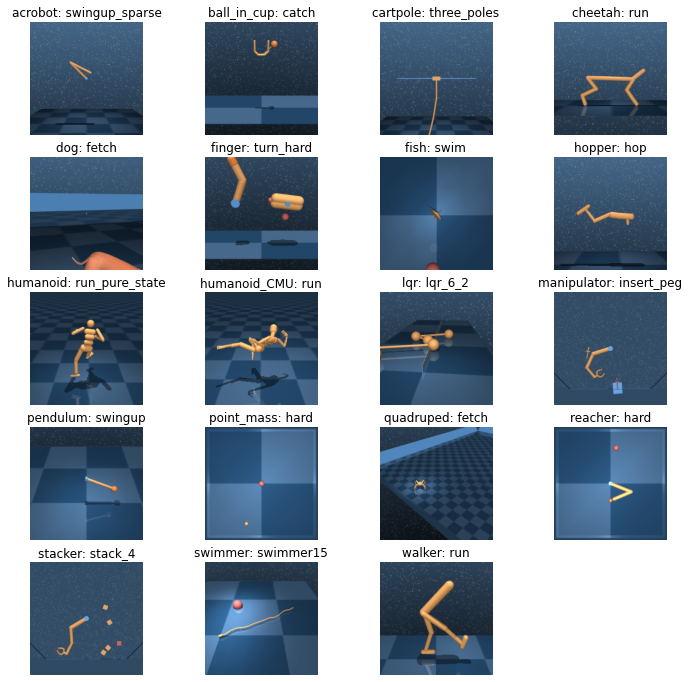

In [36]:
# #@title Visualizing an initial state of one task per domain in the Control Suite
# domains_tasks = {domain: task for domain, task in suite.ALL_TASKS}
# random_state = np.random.RandomState(42)
# num_domains = len(domains_tasks)
# n_col = num_domains // int(np.sqrt(num_domains))
# n_row = num_domains // n_col + int(0 < num_domains % n_col)
# _, ax = plt.subplots(n_row, n_col, figsize=(12, 12))
# for a in ax.flat:
#   a.axis('off')
#   a.grid(False)

# print(f'Iterating over all {num_domains} domains in the Suite:')
# for j, [domain, task] in enumerate(domains_tasks.items()):
#   print(domain, task)

#   env = suite.load(domain, task, task_kwargs={'random': random_state})
#   timestep = env.reset()
#   pixels = env.physics.render(height=200, width=200, camera_id=0)

#   ax.flat[j].imshow(pixels)
#   ax.flat[j].set_title(domain + ': ' + task)

# clear_output()

In [22]:
# #@title Iterating over tasks{vertical-output: true}

# max_len = max(len(d) for d, _ in suite.BENCHMARKING)
# for domain, task in suite.BENCHMARKING:
#   print(f'{domain:<{max_len}}  {task}')

acrobot      swingup
acrobot      swingup_sparse
ball_in_cup  catch
cartpole     balance
cartpole     balance_sparse
cartpole     swingup
cartpole     swingup_sparse
cheetah      run
finger       spin
finger       turn_easy
finger       turn_hard
fish         upright
fish         swim
hopper       stand
hopper       hop
humanoid     stand
humanoid     walk
humanoid     run
manipulator  bring_ball
pendulum     swingup
point_mass   easy
reacher      easy
reacher      hard
swimmer      swimmer6
swimmer      swimmer15
walker       stand
walker       walk
walker       run
